In [1]:
%pylab inline

import networkx as nx
from scipy.spatial import distance

Populating the interactive namespace from numpy and matplotlib


In [2]:
nr_topics = 2
n = 200

Create a Watts-Strogatz graph with 200 nodes, 10 connections per node and 10% probability of rewiring.   
This produces a model with good balance between high clustering coefficient and low average shortest path lenght.

In [3]:
G = nx.watts_strogatz_graph(n, 10, 0.1, seed=42)

Insterest vectors are sampled from a Dirichlet distribution with 2 topics

In [4]:
np.random.seed(420)
for i in list(G.nodes):
    interests = np.random.dirichlet(np.ones(nr_topics)*1./nr_topics)
    G.nodes[i]['interests'] = interests

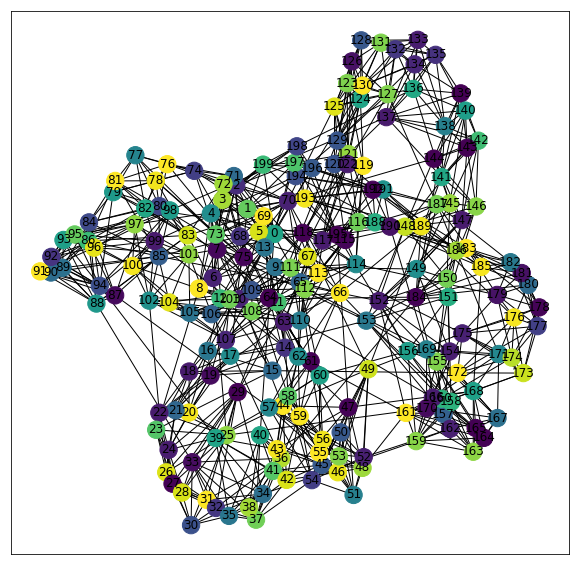

In [5]:
figure(figsize=(10,10))
c = [G.nodes[node]['interests'][0] for node in G.nodes]
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), node_color=c)

### Functions to calculate homophily

In [6]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    while True:
        a, b = np.random.randint(0, n, size=2)
        if (a, b) not in G.edges:
            return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 5000)

In [7]:
si = sim_in(G)
so = sim_out(G, 5000)
print ("In similarity: {:.4f} \nOut similarity: {:.4f} \nHomophily rate: {:.4f}".format(si, so, si/so))

In similarity: 0.7042 
Out similarity: 0.7065 
Homophily rate: 0.9968


## Select "influencers"

Start with a random node and keep adding new nodes that are far from all nodes in the influencer list

In [8]:
np.random.seed(44)

# start with a random node
influencers = [np.random.choice(n)]

for i in range(14):
    # calculate distances to current influencers
    sp = {i: nx.shortest_path(G, i) for i in influencers}
    distances = np.array([list(len(sp[j][i]) for j in influencers) for i in G.nodes()])
    # select the node fartest from all influencers
    influencers.append(distances.min(axis=1).argmax()) 

print(influencers)    

[20, 87, 136, 38, 171, 4, 50, 64, 99, 111, 147, 157, 0, 10, 26]


## Propagation step

Propagate interests to neighbors.

Influencers have a higher rate in the propagation, and don't change their interests.

In [9]:
np.random.seed(44)

for c in range(10000):
    i = np.random.choice(n)
    interests_i = G.nodes[i]['interests']
    lr = 0.5 if i in influencers else 0.01
    #lr = 0.1
    for j in list(G.neighbors(i)):
        if j in influencers:
            continue
        interests_j = G.nodes[j]['interests']
        interests_j += interests_i * lr
        interests_j /= interests_j.sum()
        G.nodes[j]['interests'] = interests_j
        
    if c%1000 == 0:
        si = sim_in(G)
        so = sim_out(G, 5000)
        print (si, so, si/so)

0.7101454776003645 0.7107955122172379 0.9990854829473449
0.9000939802680479 0.8047314447114257 1.1185023105327008
0.9266454428718949 0.7954257018517675 1.1649679419644665
0.9417483811056007 0.8050106242626178 1.169858325743506
0.9469558919045601 0.7929183503165794 1.194266586876795
0.9536808691504006 0.7959457330186187 1.1981732291390927
0.9581247073299227 0.8000026757958139 1.1976518783225503
0.9576283725157521 0.7828784236906027 1.2232146697840423
0.959689643536901 0.7919904797726275 1.2117439136546417
0.9551682924227674 0.7860232483448887 1.2151908921702297


In [10]:
si = sim_in(G)
so = sim_out(G, 5000)
print ("In similarity: {:.4f} \nOut similarity: {:.4f} \nHomophily rate: {:.4f}".format(si, so, si/so))

In similarity: 0.9552 
Out similarity: 0.7822 
Homophily rate: 1.2211


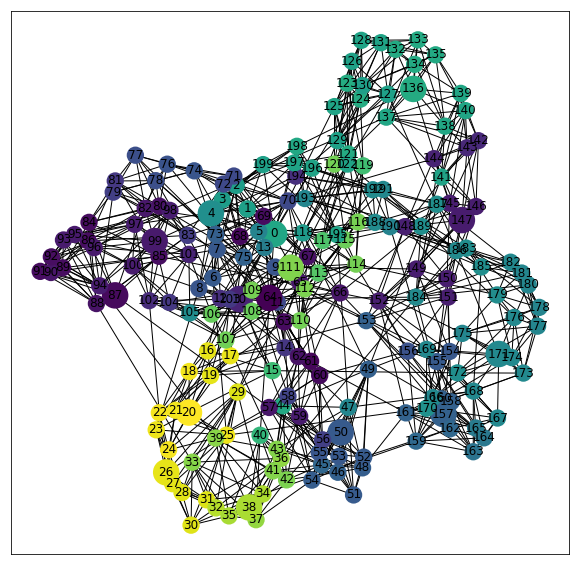

In [11]:
figure(figsize=(10,10))
c = [G.nodes[node]['interests'][0] for node in G.nodes]
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), node_color=c,
                 node_size=[(300 if n not in influencers else 600) for n in G.nodes],
                 linewidths=[(0. if n not in influencers else 2.) for n in G.nodes]
                 )